# Introduction to EHR Data Issues and AI
This notebook is a beginner-friendly guide to using AI in healthcare, with a focus on understanding how data quality issues in Electronic Health Records (EHRs) can affect model performance.

## Why It Matters
- EHRs often contain **missing**, **incorrect**, or **incomplete** data.
- These issues can cause AI models to make **inaccurate predictions**.
- Understanding these problems is **critical** before trusting AI in clinical decisions.

In [20]:
# Step 1: Load Example Data
import pandas as pd

# Simulated sample data 
data = pd.DataFrame({
    'patient_id': [1,1,1,1,1,2,2,2,2],
    'time': [1,2,3,4,5,1,2,3,4],
    'heart_rate': [80, 85, None, 90, 100, None, 95, 90, None],
    'oxygen_saturation': [98, 95, 92, None, 97, 94, None, 90, 87],
    'outcome': [1, 0, 1, 1, 0, 0, 1, 1, 0] # 1: something bad happened, 0: no critical event
})
data

,patient_id,time,heart_rate,oxygen_saturation,outcome
0,1,1,80.0,98.0,1
1,1,2,85.0,95.0,0
2,1,3,NaN,92.0,1
3,1,4,90.0,NaN,1
4,1,5,100.0,97.0,0
5,2,1,NaN,94.0,0
6,2,2,95.0,NaN,1
7,2,3,90.0,90.0,1
8,2,4,NaN,87.0,0


## Step 2: Detect Missing Values
Let’s see where the missing data is and discuss how we might handle it.

In [21]:
data.isna().sum()

patient_id           0
time                 0
heart_rate           3
oxygen_saturation    2
outcome              0
dtype: int64

## Step 3: Handle Missing Data
- We can **fill in missing values** (called imputation).
- Here we use a simple technique: **fill with the previous value**.

In [22]:
data_filled = data.ffill()
data_filled

,patient_id,time,heart_rate,oxygen_saturation,outcome
0,1,1,80.0,98.0,1
1,1,2,85.0,95.0,0
2,1,3,85.0,92.0,1
3,1,4,90.0,92.0,1
4,1,5,100.0,97.0,0
5,2,1,100.0,94.0,0
6,2,2,95.0,94.0,1
7,2,3,90.0,90.0,1
8,2,4,90.0,87.0,0


## Step 4: Train a Simple AI Model
Let’s use a very basic AI model (logistic regression) to predict the outcome.

Now that we have filled in missing values, let's use this cleaned data to train an AI model. 

We will:

1. Use two important features: heart_rate and oxygen_saturation.

2. Try to predict the outcome (0 = stable, 1 = critical).

3. Train a very simple model called Logistic Regression. It's often used for yes/no predictions.

4. Split the data into:

    * Training set (what the model learns from)
    * Testing set (to check how well it learned)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Predict the outcome by using heart rate and oxygen saturation
X = data_filled[['heart_rate', 'oxygen_saturation']]
y = data_filled['outcome']

# Split the data into training and test sets (67% train, 33% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create the model
model = LogisticRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Predict outcomes for the test data
predictions = model.predict(X_test)

# Check how accurate the model is
probs = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, predictions)

print('The accuracy score:', acc)

The accuracy score: 0.6666666666666666


## Understanding Model Performance with Visuals

Now let’s look at how well our model performs using easy-to-understand graphs:

__Confusion Matrix__
This shows how many times the model was right or wrong:

 * ✅ True Positive: The model _predicted 1_ and it was _actually 1_.
 * ❌ False Positive: The model _predicted 1_ but it was _actually 0_.
 * ✅ True Negative: The model _predicted 0_ and it was _actually 0_.
 * ❌ False Negative: The model _predicted 0_ but it was _actually 1_.

__ROC Curve (Receiver Operating Characteristic)__
This graph tells us how good the model is at distinguishing between the two classes.
 * The closer the curve is to the top-left corner, the better the model.
 * The AUC (Area Under Curve) tells us the overall performance (1.0 = perfect, 0.5 = random).

__Prediction Probability Distribution__

This shows __how confident__ the model is when it makes predictions.

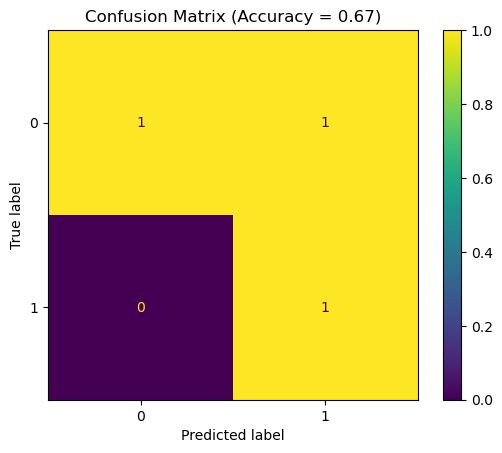

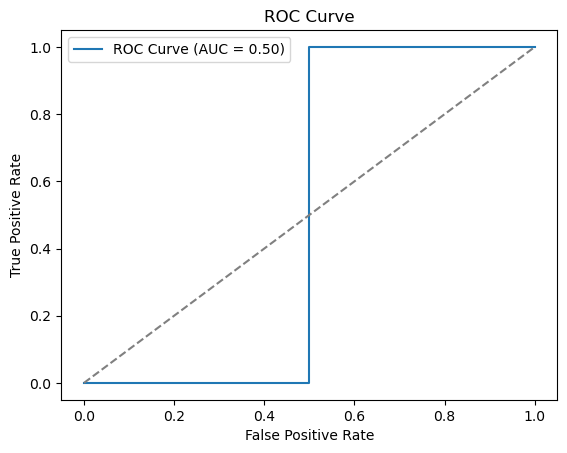

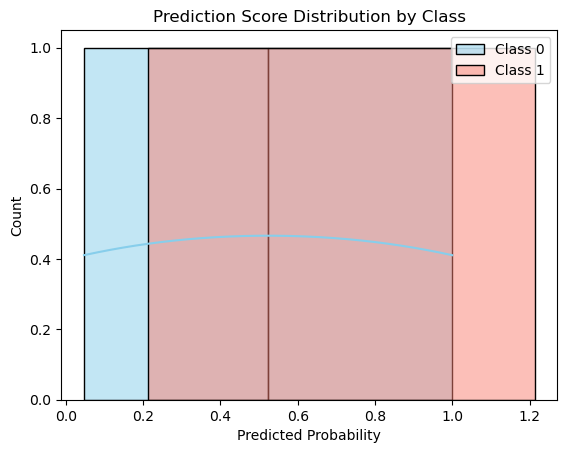

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
fig_cm, ax_cm = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=ax_cm)
ax_cm.set_title(f'Confusion Matrix (Accuracy = {accuracy_score(y_test, predictions):.2f})')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
fig_roc, ax_roc = plt.subplots()
ax_roc.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax_roc.set_title("ROC Curve")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend()
plt.show()

# Prediction Distribution
fig_dist, ax_dist = plt.subplots()
sns.histplot(probs[y_test == 0], label="Class 0", color="skyblue", kde=True, ax=ax_dist)
sns.histplot(probs[y_test == 1], label="Class 1", color="salmon", kde=True, ax=ax_dist)
ax_dist.set_title("Prediction Score Distribution by Class")
ax_dist.set_xlabel("Predicted Probability")
ax_dist.legend()
plt.show()

🎉 **Conclusion**: 

This simple model helps us see how missing data is handled and how we can start using AI tools in healthcare carefully and responsibly.